In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest

In [3]:
df = pd.read_csv("Housing.csv")

In [4]:
# Checking the data
print(df.shape)
print(df.dtypes)
print(df.head())

(545, 13)
price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1       

In [5]:
#Checking for duplicates
df = df.drop_duplicates().reset_index(drop=True)

In [7]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = [c for c in df.columns if c not in numeric_cols]
print("Numeric:", numeric_cols)
print("Categorical:", non_numeric_cols)

Numeric: ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
Categorical: ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']


In [9]:
#Checking null values
if df.isnull().sum().sum() > 0:
    num_imputer = SimpleImputer(strategy="median")
    df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])
    if non_numeric_cols:
        cat_imputer = SimpleImputer(strategy="most_frequent")
        df[non_numeric_cols] = cat_imputer.fit_transform(df[non_numeric_cols])
    print("Missing values imputed.")
else:
    print("No missing values found.")

No missing values found.


In [10]:
#Univariate Analysis
print(df[numeric_cols].describe().T)

           count          mean           std        min        25%        50%  \
price      545.0  4.766729e+06  1.870440e+06  1750000.0  3430000.0  4340000.0   
area       545.0  5.150541e+03  2.170141e+03     1650.0     3600.0     4600.0   
bedrooms   545.0  2.965138e+00  7.380639e-01        1.0        2.0        3.0   
bathrooms  545.0  1.286239e+00  5.024696e-01        1.0        1.0        1.0   
stories    545.0  1.805505e+00  8.674925e-01        1.0        1.0        2.0   
parking    545.0  6.935780e-01  8.615858e-01        0.0        0.0        0.0   

                 75%         max  
price      5740000.0  13300000.0  
area          6360.0     16200.0  
bedrooms         3.0         6.0  
bathrooms        2.0         4.0  
stories          2.0         4.0  
parking          1.0         3.0  


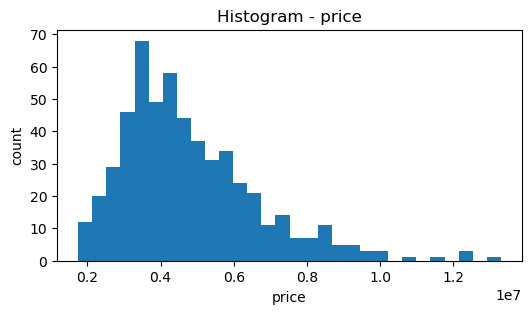

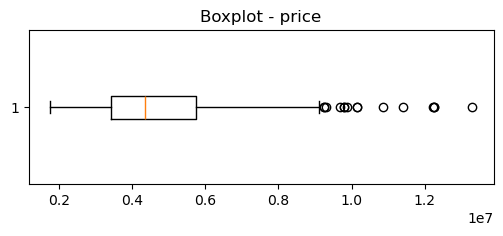

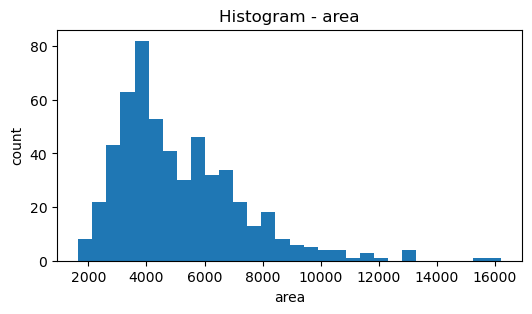

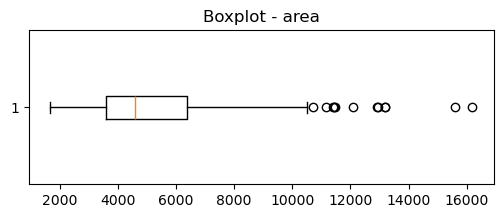

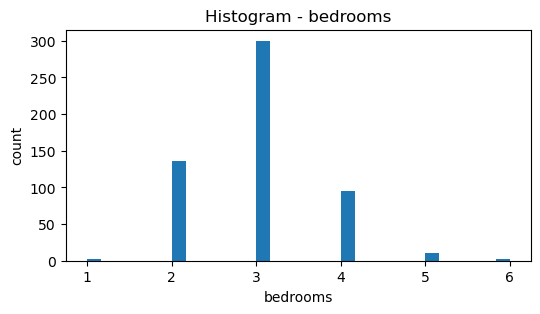

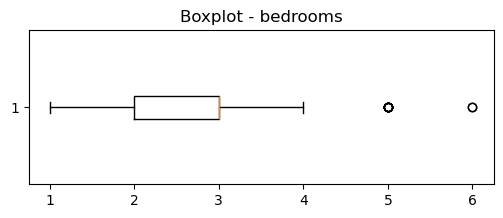

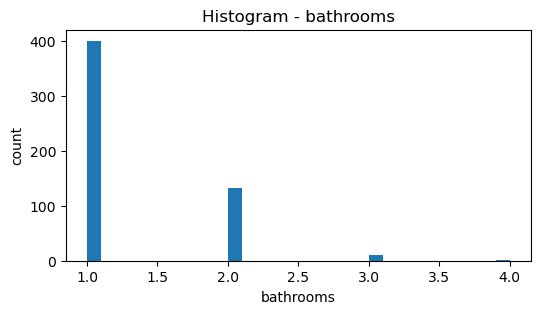

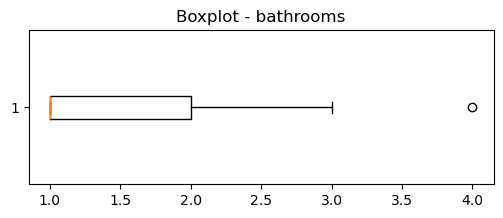

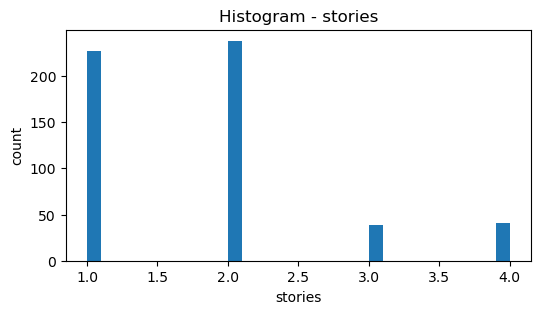

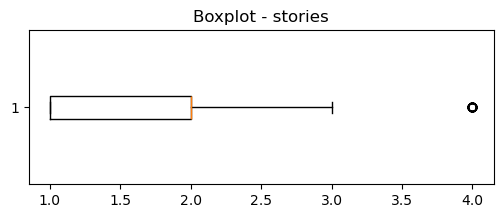

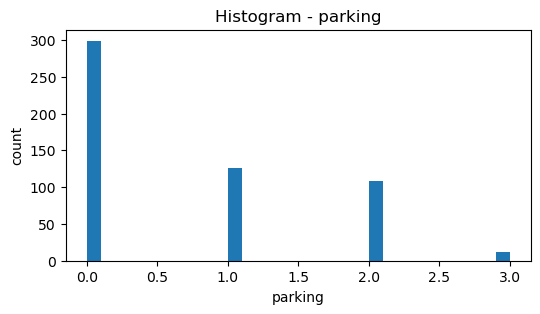

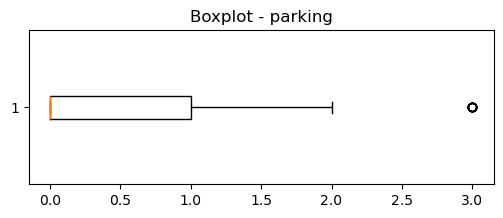

In [11]:
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f'Histogram - {col}')
    plt.xlabel(col); plt.ylabel('count')
    plt.show()

    plt.figure(figsize=(6,2))
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(f'Boxplot - {col}')
    plt.show()

In [12]:
possible_targets = ['median_house_value', 'price', 'SalePrice', 'MEDV', 'target', 'house_value', 'Price']
target_col = None
for t in possible_targets:
    if t in df.columns:
        target_col = t
        break
if target_col is None:
    target_col = numeric_cols[-1]  

print("Target chosen:", target_col)


Target chosen: price


In [14]:
#Bivariate Analysis
corr = df[numeric_cols].corr()
corr_with_target = corr[target_col].sort_values(ascending=False)
print("Correlation with target:\n", corr_with_target)

Correlation with target:
 price        1.000000
area         0.535997
bathrooms    0.517545
stories      0.420712
parking      0.384394
bedrooms     0.366494
Name: price, dtype: float64


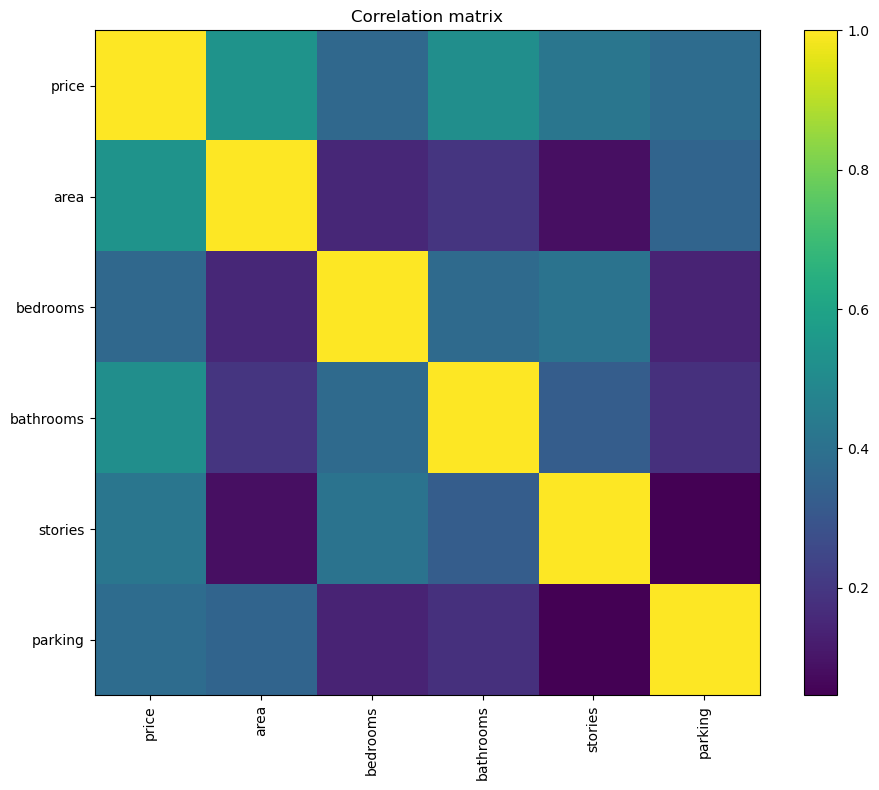

In [15]:
plt.figure(figsize=(10,8))
plt.imshow(corr, interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Correlation matrix')
plt.tight_layout()
plt.show()

In [16]:
#Selecting Features
X_all = df.drop(columns=[target_col])
if non_numeric_cols:
    X_all = pd.get_dummies(X_all, drop_first=True)
X_all = X_all.select_dtypes(include=[np.number])
y = df[target_col].values

In [17]:
k = min(8, X_all.shape[1])
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k=k)
selector.fit(X_all, y)
scores = pd.Series(selector.scores_, index=X_all.columns).sort_values(ascending=False)
top_features = scores.head(k).index.tolist()
print("Top features:", top_features)
print(scores.head(k))

Top features: ['area', 'bathrooms', 'stories', 'parking', 'bedrooms']
area         218.884081
bathrooms    198.654521
stories      116.780402
parking       94.143328
bedrooms      84.251022
dtype: float64


In [19]:
#Performing Train-test split test
X = X_all[top_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
#Training the model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Coefficients (since we scaled, these are per-stddev)
coefficients = pd.Series(lr.coef_, index=top_features).sort_values(key=abs, ascending=False)
print("Intercept:", lr.intercept_)
print("Coefficients:")
print(coefficients)

Intercept: 4706527.385321101
Coefficients:
area         680058.424141
bathrooms    565408.617936
stories      424354.811764
parking      288348.772668
bedrooms     112973.185629
dtype: float64


In [21]:
#Checking MSE, RMSE, MAE, R2
y_pred = lr.predict(X_test_scaled)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")

MSE: 2292721545725.3662
RMSE: 1514173.5520
MAE: 1127483.3523
R-squared: 0.5464


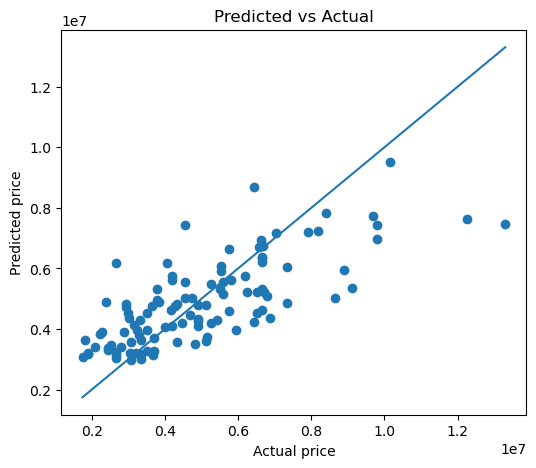

In [22]:
#Visualizing Predicted v/s Actual Value
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual ' + target_col)
plt.ylabel('Predicted ' + target_col)
plt.title('Predicted vs Actual')
minv = min(np.min(y_test), np.min(y_pred))
maxv = max(np.max(y_test), np.max(y_pred))
plt.plot([minv, maxv], [minv, maxv])
plt.show()

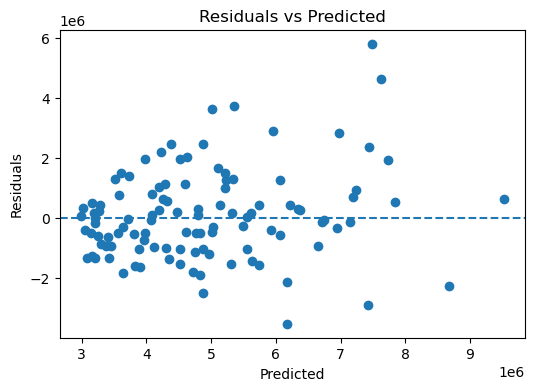

In [23]:
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals)
plt.axhline(0, linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

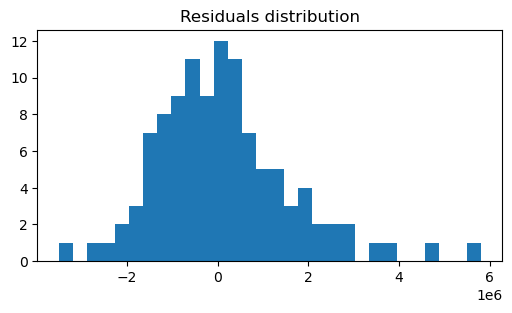

In [24]:
plt.figure(figsize=(6,3))
plt.hist(residuals, bins=30)
plt.title('Residuals distribution')
plt.show()

In [26]:
#Property size, number of bathrooms, and stories are the top physical factors.
#Amenities like air conditioning and parking availability add significant premium value.
#Developers or sellers should focus on expanding usable area and adding amenities like A/C, parking to increase market value.
#Buyers can use this model to estimate fair prices based on property features and identify overpriced listings.
#The higher mullticollinearity needs to be further studied. It could also be studied in terms of market segmentation for luxury and bu